In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
import numpy as np
import pandas as pd
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn import datasets, manifold
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import KernelPCA

ModuleNotFoundError: No module named 'umap'

In [62]:
class MDS:

    n_components = 2
    dissimilarity = "euclidean"
    embedding_ = None
    dissimilarity_matrix_ = None

    def __init__(self, n_components:int=2, dissimilarity="euclidean"):

        self.n_components = n_components
        if not dissimilarity in ["euclidean", "cosine", "precomputed"]:
            raise ValueError()
        self.dissimilarity = dissimilarity


    def fit(self, X:np.ndarray):
        
        n = X.shape[0]

        if self.dissimilarity == "euclidean":
            tmp = np.tile(X, (n, 1, 1))
            self.dissimilarity_matrix_ = np.sqrt(np.square(tmp - tmp.transpose((1, 0, 2))).sum(axis=2))
        elif self.dissimilarity == "cosine":
            tmp = np.dot(X, X.T)
            norm = np.sqrt(np.square(X).sum(axis=1))
            self.dissimilarity_matrix_ = 1 - tmp / norm / norm.reshape(-1, 1)
        else:
            self.dissimilarity_matrix_ = X
        
        h = np.eye(n) - np.ones((n, n)) / n
        k = -0.5 * np.dot(np.dot(h, self.dissimilarity_matrix_), h)
        evl, evc = np.linalg.eigh(k)
        evl_asort = evl.argsort()
        eids = evl_asort[::-1][:self.n_components]
        lamb = np.diag(evl[eids])
        v = evc[:, eids]
        self.embedding_ = np.dot(np.sqrt(lamb), v.T).T

    def fit_transform(self, X:np.ndarray):

        self.fit(X)
        return self.embedding_

In [63]:
def sammon(x, n, display = 1, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):



    """Perform Sammon mapping on dataset x

    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 

    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).

    An N-dimensional output map is generated by y = sammon(x,n) .

    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):

       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'

    The default options are retrieved by calling sammon(x) with no
    parameters.

    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot

    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].

    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.

    Copyright   : (c) Dr Gavin C. Cawley, November 2007.

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA

    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

# Swiss Roll

In [ ]:
# En lugar de esto
# 1) Leer el xlsx con pandas.read_excel
# 2) asignar a sr_points todas las columnas menos la ultima -> Ej: iloc [:, :-1]
# 3) Asignar a sr_color la ultima columna -> Ej: iloc [:, -1]

sr_points, sr_color = datasets.make_swiss_roll(n_samples=1500, random_state=0)

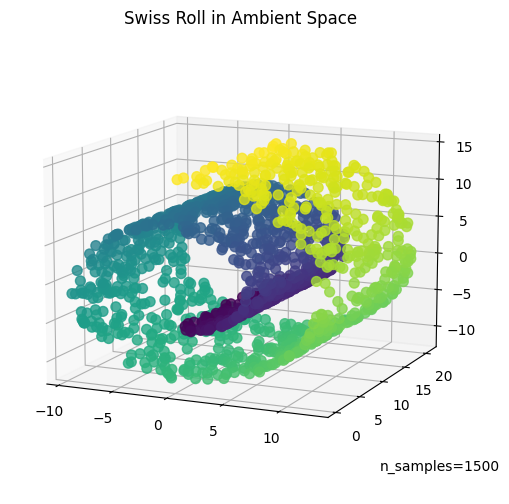

In [65]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=50, alpha=0.8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

Text(0.5, 1.0, 'Isomap with k = 8')

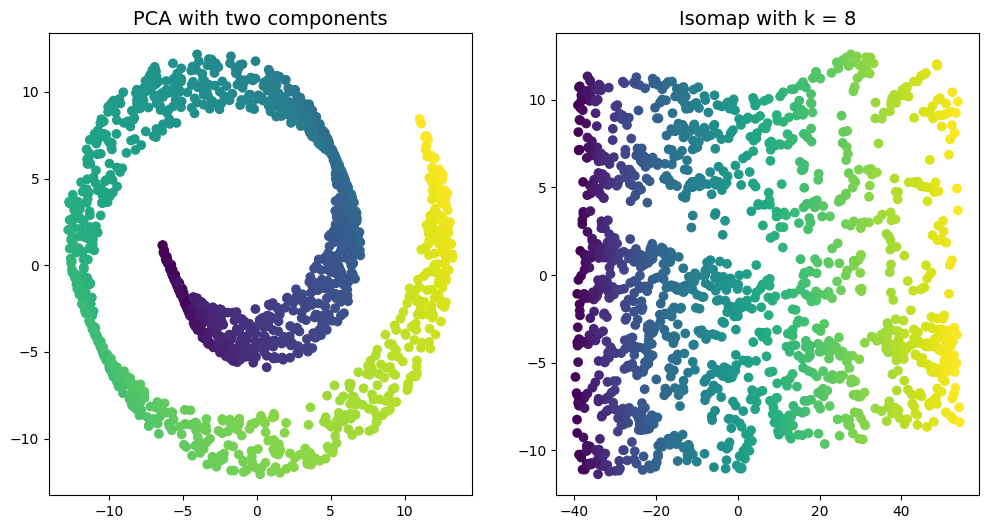

In [66]:

fig = plt.figure(figsize=(12,6))
k = 8

points = sr_points.copy()
color = sr_color.copy()

pca = PCA(n_components=2)
pca.fit(points)
X_pca = pca.transform(points)

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=color)
ax.set_title('PCA with two components', size=14)

model = Isomap(n_components=2, n_neighbors=k)
X_iso = model.fit_transform(points)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X_iso[:, 0], X_iso[:, 1], c=color)
ax.set_title('Isomap with k = ' + str(k), size=14)

In [67]:

n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold
params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}


Text(0.5, 1.0, 'LLE standard')

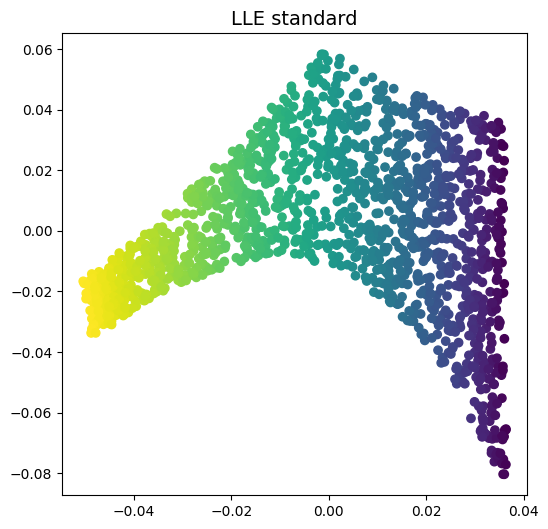

In [68]:
points = sr_points.copy()
color = sr_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="standard", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE standard', size=14)

Text(0.5, 1.0, 'LLE ltsa')

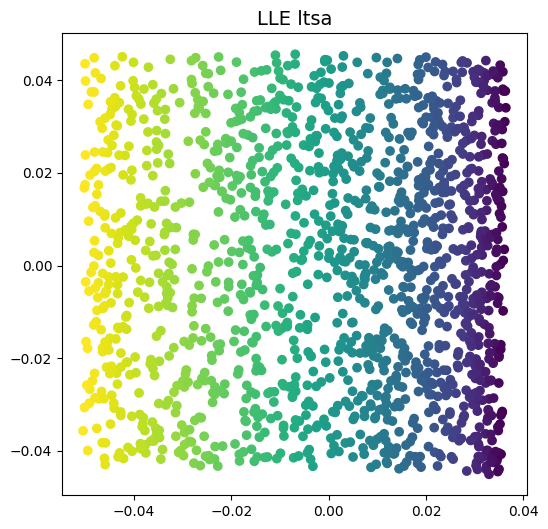

In [69]:
points = sr_points.copy()
color = sr_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="ltsa", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE ltsa', size=14)

Text(0.5, 1.0, 'LLE hessian')

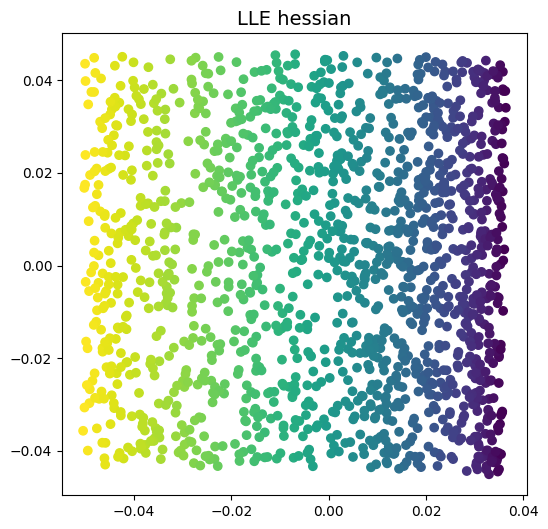

In [70]:
points = sr_points.copy()
color = sr_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="hessian", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE hessian', size=14)

Text(0.5, 1.0, 'LLE modified')

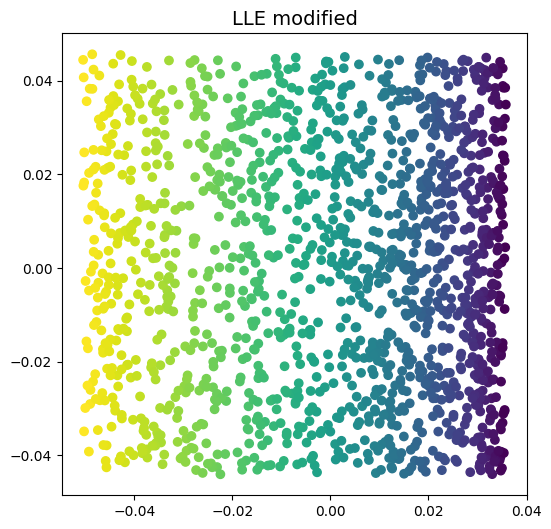

In [71]:
points = sr_points.copy()
color = sr_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="modified", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE modified', size=14)

Text(0.5, 1.0, 'MDS')

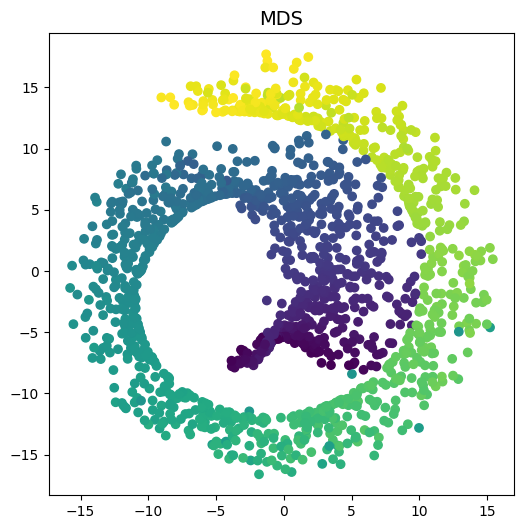

In [72]:
points = sr_points.copy()
color = sr_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

Text(0.5, 1.0, 'MDS')

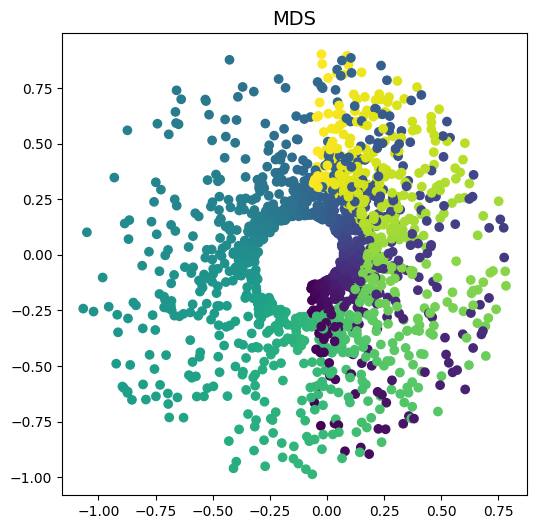

In [73]:

points = sr_points.copy()
color = sr_color.copy()
dis_matrix = pairwise_distances(points, metric = 'cosine')
fig = plt.figure(figsize=(6,6))
model = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
    dissimilarity="precomputed"
)
X = model.fit_transform(dis_matrix)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

Text(0.5, 1.0, 'MDS')

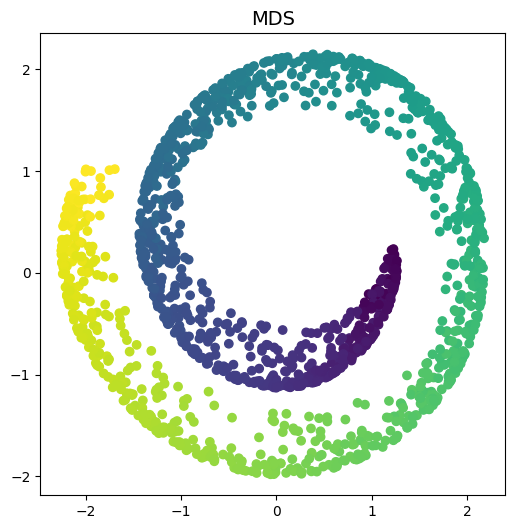

In [74]:
points = sr_points.copy()
color = sr_color.copy()
mds = MDS()
X = mds.fit_transform(points)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

Text(0.5, 1.0, 'Spectral Embedding')

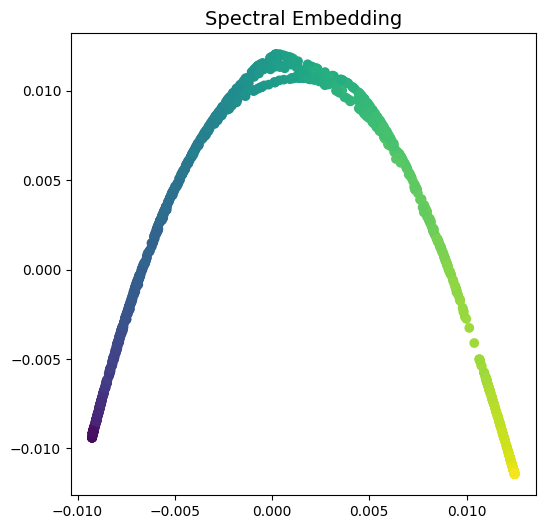

In [75]:
points = sr_points.copy()
color = sr_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors, random_state=42
)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('Spectral Embedding', size=14)

TolFun exceeded: Optimisation terminated


Text(0.5, 1.0, 'Sammon')

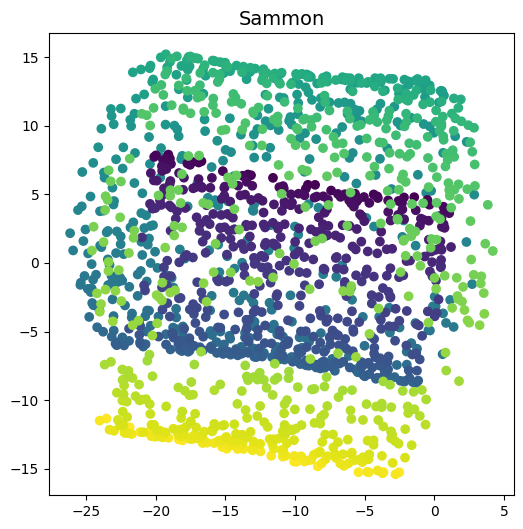

In [76]:
points = sr_points.copy()
color = sr_color.copy()
(sp,index) = np.unique(points,axis=0,return_index=True)
(y,E) = sammon(sp, 2)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y[:, 0], y[:, 1], c=color[index])
ax.set_title('Sammon', size=14)


/Users/lucianosanchez/dataenv3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


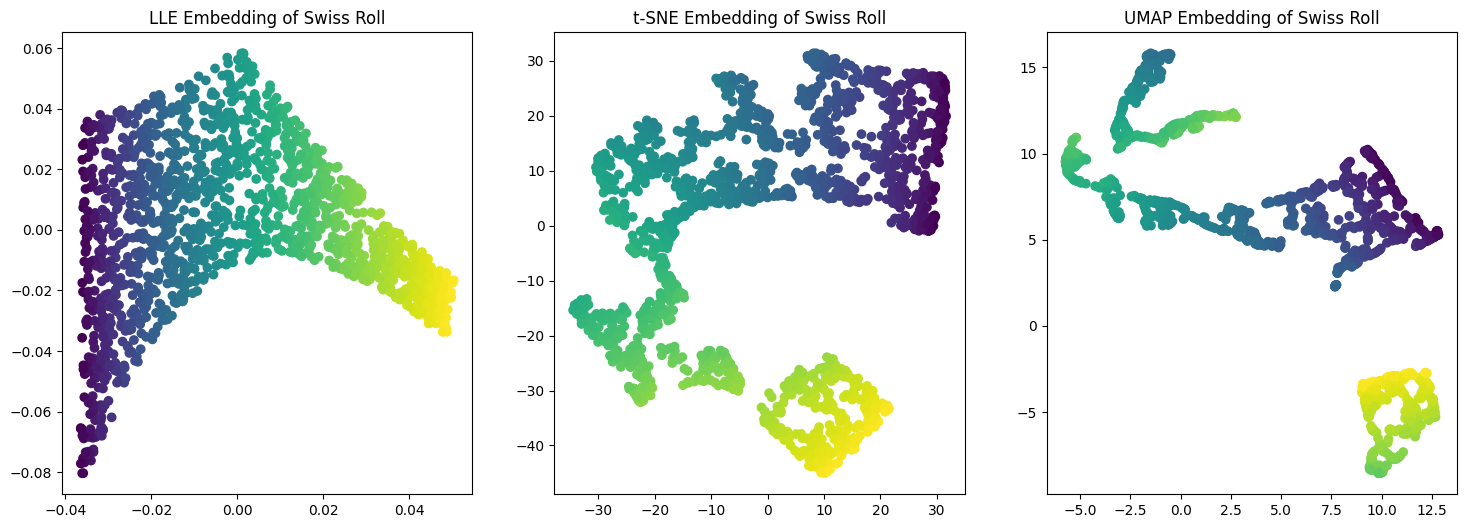

In [125]:
points = sr_points.copy()
color = sr_color.copy()
sr_lle, sr_err = manifold.locally_linear_embedding(
    points, n_neighbors=12, n_components=2
)

sr_tsne = manifold.TSNE(n_components=2, perplexity=40, random_state=0).fit_transform(
    points
)

pumap = UMAP(n_components=2, init="random", random_state=0)
sr_umap = pumap.fit_transform(points)

fig, axs = plt.subplots(figsize=(18, 6), ncols=3)
axs[0].scatter(sr_lle[:, 0], sr_lle[:, 1], c=color)
axs[0].set_title("LLE Embedding of Swiss Roll")
axs[1].scatter(sr_tsne[:, 0], sr_tsne[:, 1], c=color)
_ = axs[1].set_title("t-SNE Embedding of Swiss Roll")
axs[2].scatter(sr_umap[:, 0], sr_umap[:, 1], c=color)
_ = axs[2].set_title("UMAP Embedding of Swiss Roll")

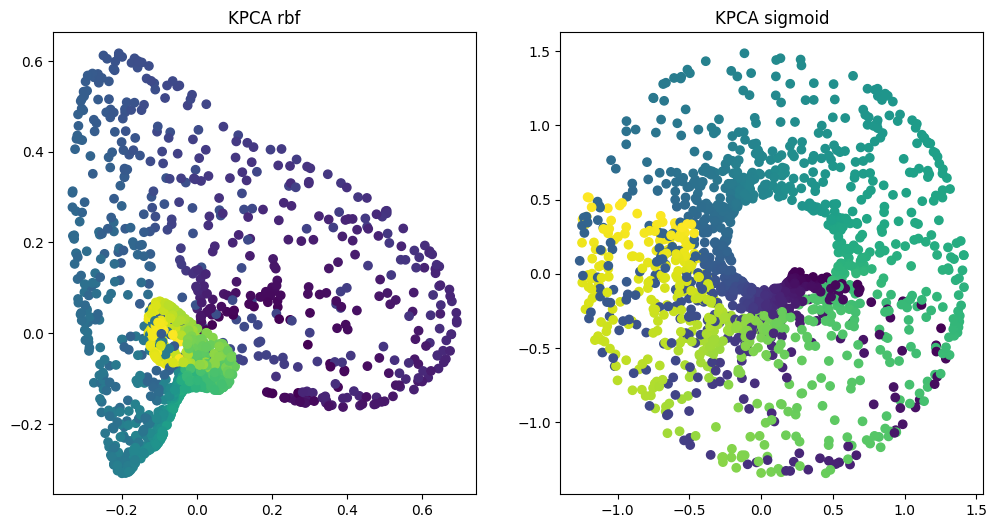

In [114]:

points = sr_points.copy()
color = sr_color.copy()
transformer_1 = KernelPCA(n_components=2, kernel='rbf',gamma=0.05)
kpca_1 = transformer_1.fit_transform(points)
transformer_2 = KernelPCA(n_components=2, kernel='sigmoid')
kpca_2 = transformer_2.fit_transform(points)
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].scatter(kpca_1[:, 0], kpca_1[:, 1], c=color)
axs[0].set_title("KPCA rbf")
axs[1].scatter(kpca_2[:, 0], kpca_2[:, 1], c=color)
_ = axs[1].set_title("KPCA sigmoid")


# Swiss Roll con agujero

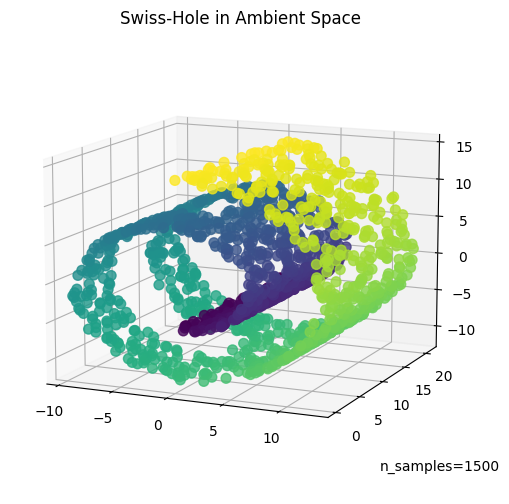

In [78]:
sh_points, sh_color = datasets.make_swiss_roll(
    n_samples=1500, hole=True, random_state=0
)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    sh_points[:, 0], sh_points[:, 1], sh_points[:, 2], c=sh_color, s=50, alpha=0.8
)
ax.set_title("Swiss-Hole in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

Text(0.5, 1.0, 'Isomap with k = 8')

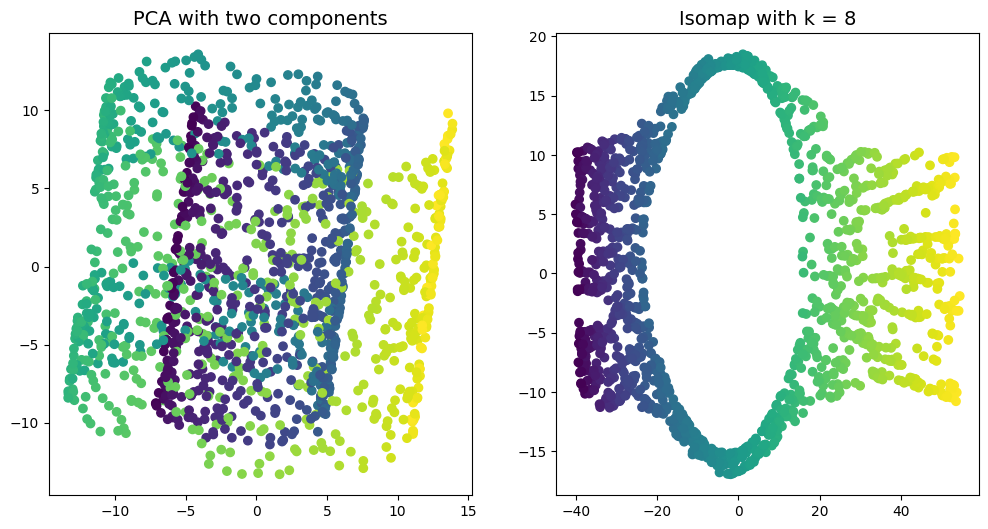

In [79]:
points = sh_points.copy()
color = sh_color.copy()

fig = plt.figure(figsize=(12,6))
k = 8

pca = PCA(n_components=2)
pca.fit(points)
X_pca = pca.transform(points)

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=color)
ax.set_title('PCA with two components', size=14)

model = Isomap(n_components=2, n_neighbors=k)
X_iso = model.fit_transform(points)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X_iso[:, 0], X_iso[:, 1], c=color)
ax.set_title('Isomap with k = ' + str(k), size=14)

Text(0.5, 1.0, 'LLE')

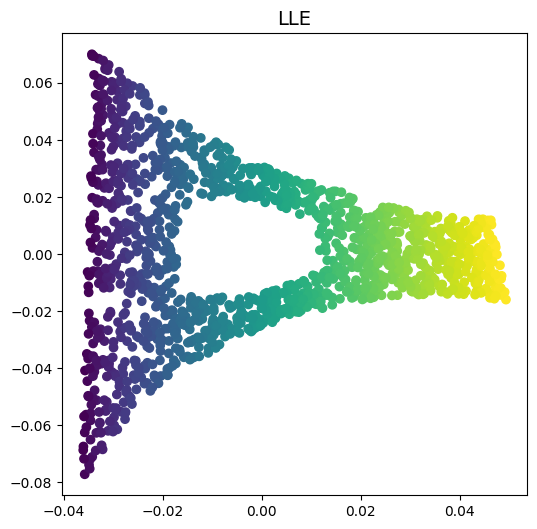

In [80]:
points = sh_points.copy()
color = sh_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="standard", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE', size=14)

Text(0.5, 1.0, 'LLE ltsa')

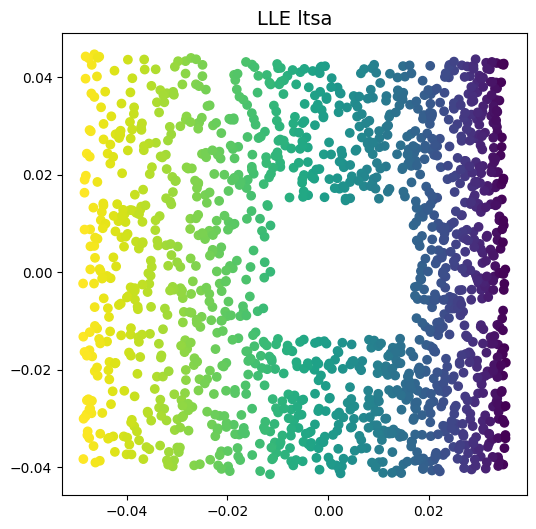

In [81]:
points = sh_points.copy()
color = sh_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="ltsa", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE ltsa', size=14)

Text(0.5, 1.0, 'LLE hessian')

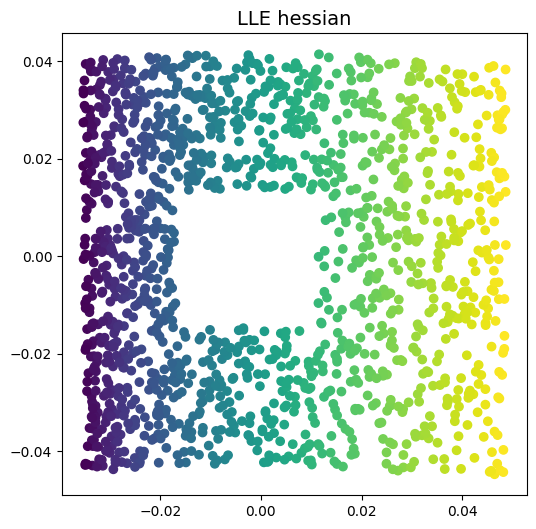

In [82]:
points = sh_points.copy()
color = sh_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="hessian", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE hessian', size=14)

Text(0.5, 1.0, 'LLE modified')

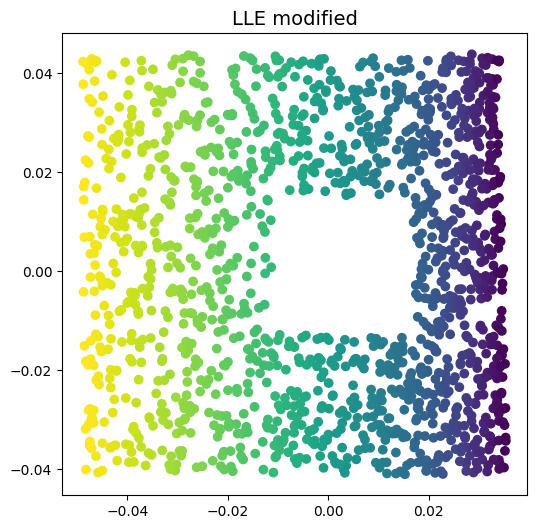

In [83]:
points = sh_points.copy()
color = sh_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="modified", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE modified', size=14)

Text(0.5, 1.0, 'MDS')

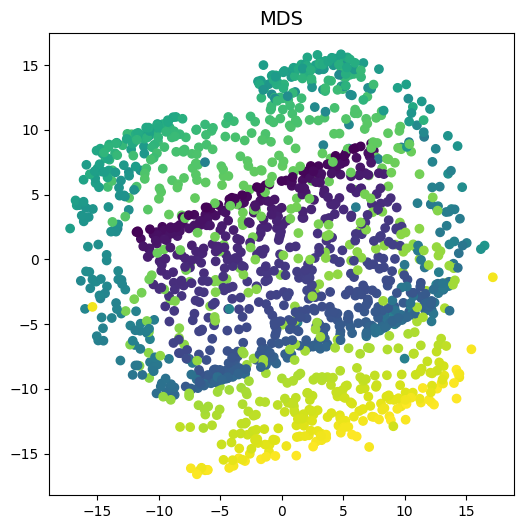

In [84]:
points = sh_points.copy()
color = sh_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

Text(0.5, 1.0, 'MDS')

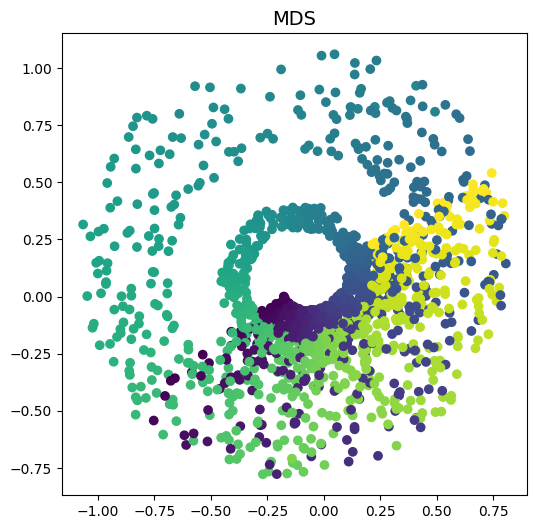

In [85]:
points = sh_points.copy()
color = sh_color.copy()
dis_matrix = pairwise_distances(points, metric = 'cosine')
fig = plt.figure(figsize=(6,6))
model = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
    dissimilarity="precomputed"
)
X = model.fit_transform(dis_matrix)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

Text(0.5, 1.0, 'MDS')

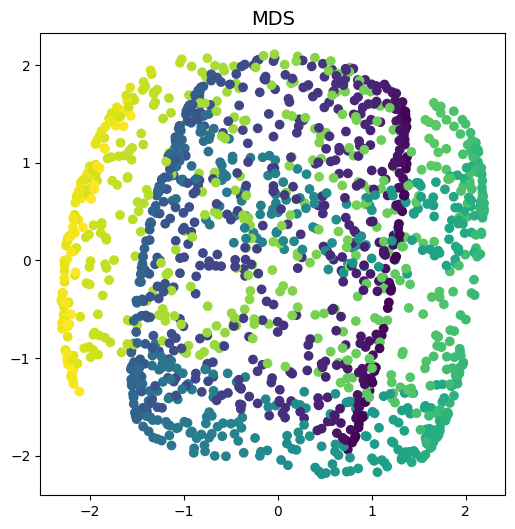

In [86]:
points = sh_points.copy()
color = sh_color.copy()
mds = MDS()
X = mds.fit_transform(points)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

Text(0.5, 1.0, 'Spectral Embedding')

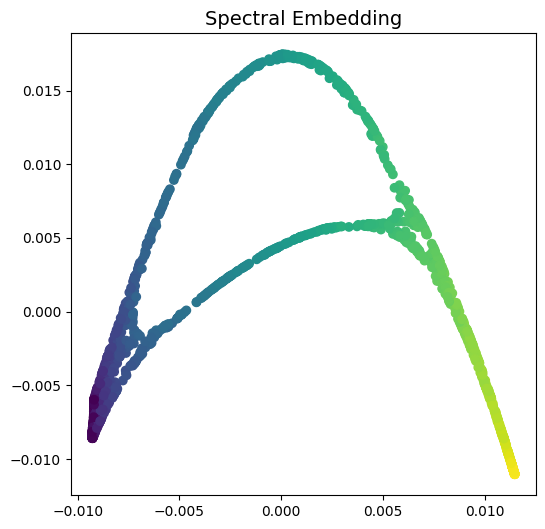

In [87]:
points = sh_points.copy()
color = sh_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors, random_state=42
)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('Spectral Embedding', size=14)

TolFun exceeded: Optimisation terminated


Text(0.5, 1.0, 'Sammon')

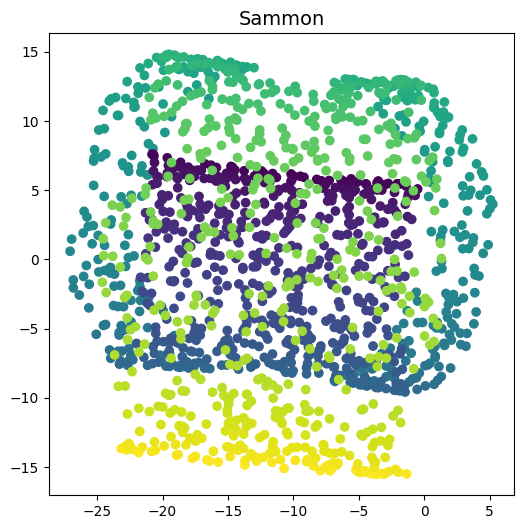

In [88]:
points = sh_points.copy()
color = sh_color.copy()
(sp,index) = np.unique(points,axis=0,return_index=True)
(y,E) = sammon(sp, 2)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y[:, 0], y[:, 1], c=color[index])
ax.set_title('Sammon', size=14)

/Users/lucianosanchez/dataenv3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


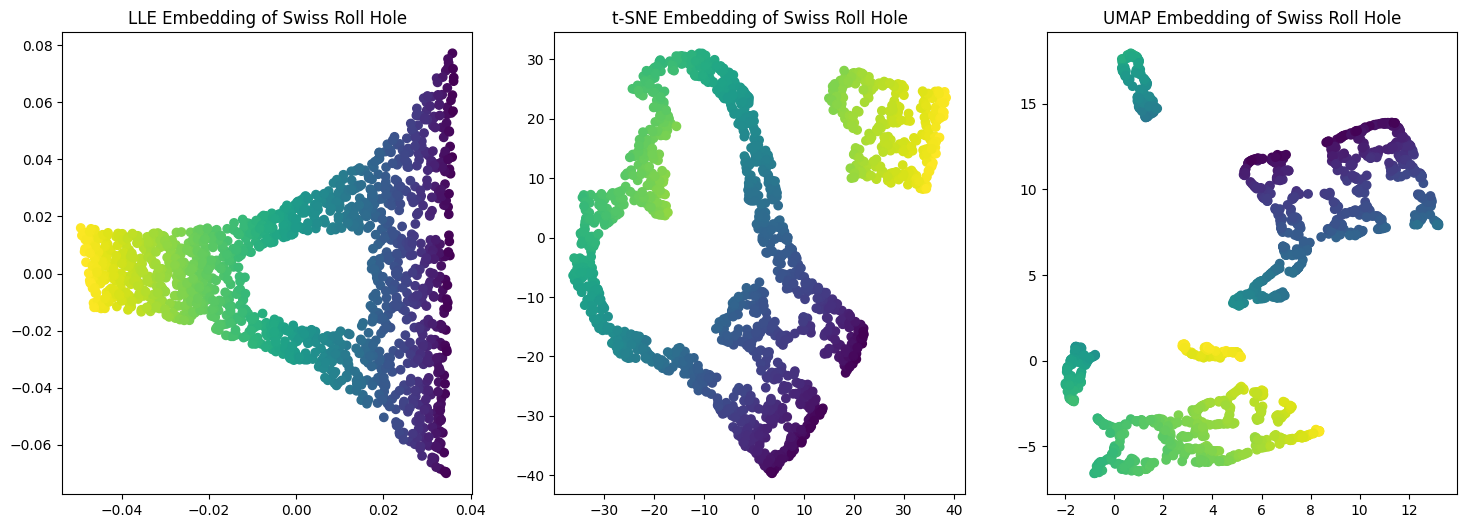

In [126]:
points = sh_points.copy()
color = sh_color.copy()
sr_lle, sr_err = manifold.locally_linear_embedding(
    points, n_neighbors=12, n_components=2
)

sr_tsne = manifold.TSNE(n_components=2, perplexity=40, random_state=0).fit_transform(
    points
)

pumap = UMAP(n_components=2, init="random", random_state=0)
sr_umap = pumap.fit_transform(points)

fig, axs = plt.subplots(figsize=(18, 6), ncols=3)
axs[0].scatter(sr_lle[:, 0], sr_lle[:, 1], c=color)
axs[0].set_title("LLE Embedding of Swiss Roll Hole")
axs[1].scatter(sr_tsne[:, 0], sr_tsne[:, 1], c=color)
_ = axs[1].set_title("t-SNE Embedding of Swiss Roll Hole")
axs[2].scatter(sr_umap[:, 0], sr_umap[:, 1], c=color)
_ = axs[2].set_title("UMAP Embedding of Swiss Roll Hole")

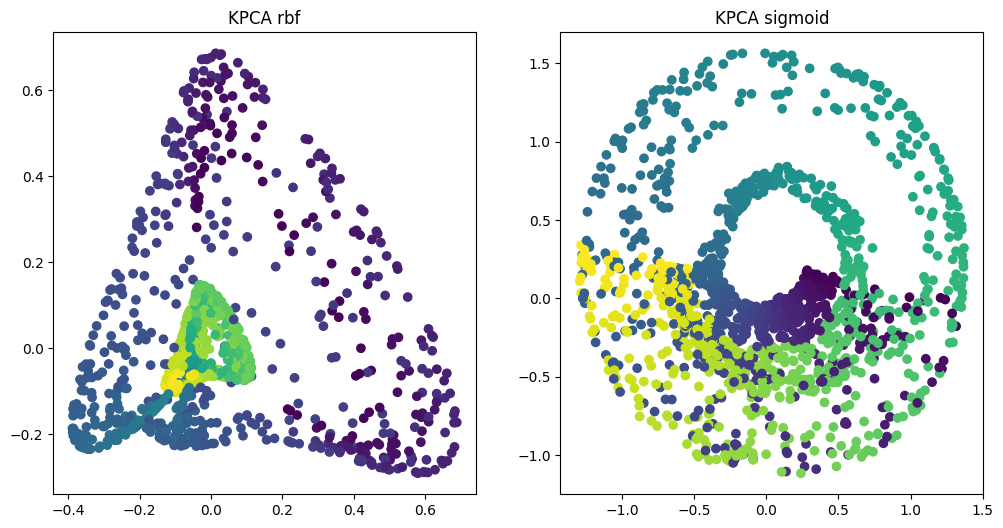

In [115]:

points = sh_points.copy()
color = sh_color.copy()
transformer_1 = KernelPCA(n_components=2, kernel='rbf',gamma=0.05)
kpca_1 = transformer_1.fit_transform(points)
transformer_2 = KernelPCA(n_components=2, kernel='sigmoid')
kpca_2 = transformer_2.fit_transform(points)
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].scatter(kpca_1[:, 0], kpca_1[:, 1], c=color)
axs[0].set_title("KPCA rbf")
axs[1].scatter(kpca_2[:, 0], kpca_2[:, 1], c=color)
_ = axs[1].set_title("KPCA sigmoid")

# Open box

In [91]:

ladox = range(10)
ladoy = range(10)
base_l = [[(x, y, 0) for x in ladox ] for y in ladoy]
color_l = [[0 for x in ladox ] for y in ladoy]
lado_1 = [[(x, 0, y) for x in ladox ] for y in ladoy]
color_1 = [[y for x in ladox ] for y in ladoy]
lado_2 = [[(0, x, y) for x in ladox ] for y in ladoy]
color_2 = [[y for x in ladox ] for y in ladoy]
lado_3 = [[(x, 9, y) for x in ladox ] for y in ladoy]
color_3 = [[y for x in ladox ] for y in ladoy]
lado_4 = [[(9, x, y) for x in ladox ] for y in ladoy]
color_4 = [[y for x in ladox ] for y in ladoy]
base_h = [[(x+10, y, 9) for x in ladox ] for y in ladoy]
color_h = [[9 for x in ladox ] for y in ladoy]
ob_points = np.vstack(base_l + lado_1 + lado_2 + lado_3 + lado_4 + base_h)
ob_color = np.vstack(color_l + color_1 + color_2 + color_3 +color_4 + color_h).reshape(-1)

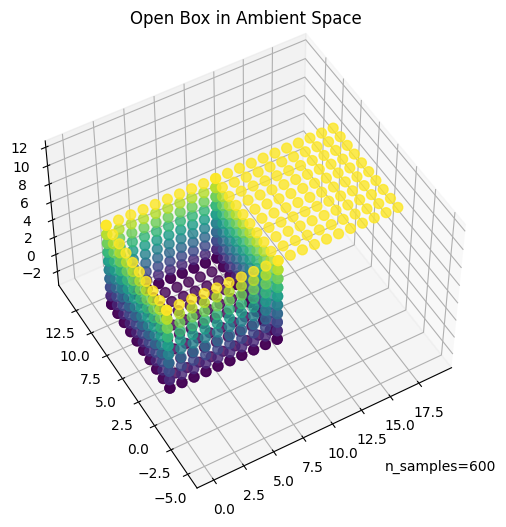

In [92]:
points = ob_points.copy()
color = ob_color.copy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    points[:, 0], points[:, 1], points[:, 2], c=color,s=50, alpha=0.8
)
ax.set_title("Open Box in Ambient Space")
ax.axis('equal')
ax.view_init(azim=-120, elev=50)
_ = ax.text2D(0.8, 0.05, s="n_samples="+str(len(points)), transform=ax.transAxes)

Text(0.5, 1.0, 'Isomap with k = 8')

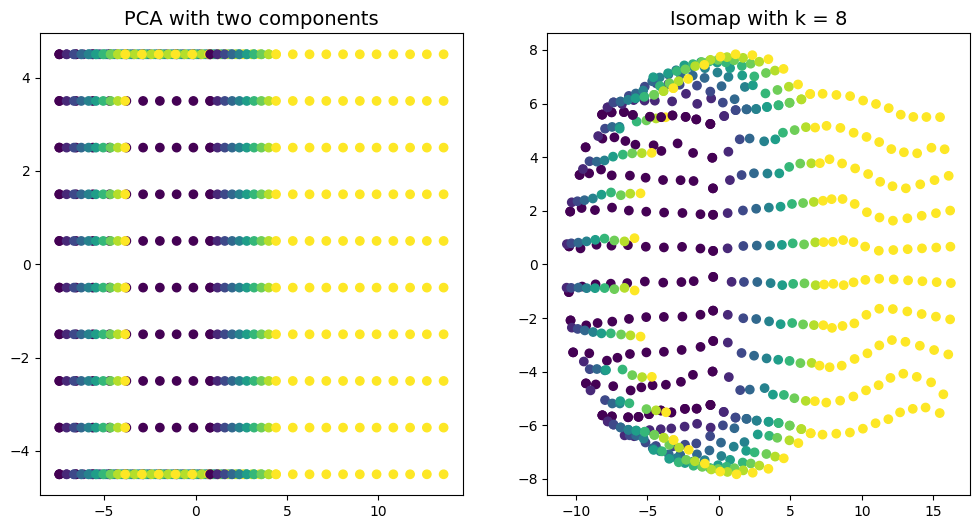

In [93]:
points = ob_points.copy()
color = ob_color.copy()

fig = plt.figure(figsize=(12,6))
k = 8

pca = PCA(n_components=2)
pca.fit(points)
X_pca = pca.transform(points)

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=color)
ax.set_title('PCA with two components', size=14)

model = Isomap(n_components=2, n_neighbors=k)
X_iso = model.fit_transform(points)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X_iso[:, 0], X_iso[:, 1], c=color)
ax.set_title('Isomap with k = ' + str(k), size=14)

Text(0.5, 1.0, 'LLE standard')

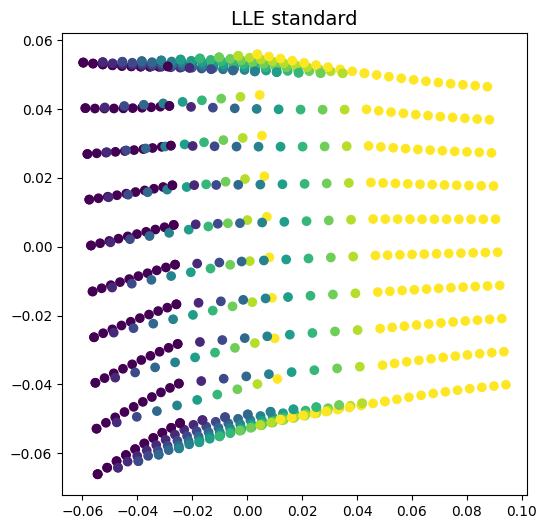

In [117]:
points = ob_points.copy()
color = ob_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="standard", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE standard', size=14)

Text(0.5, 1.0, 'LLE LTSA')

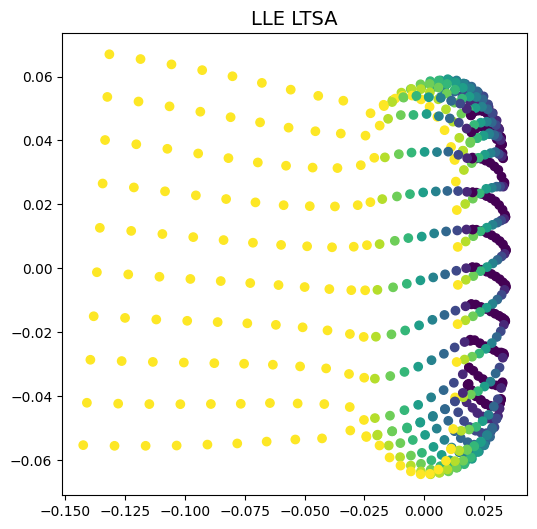

In [120]:
points = ob_points.copy()
color = ob_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="ltsa", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE LTSA', size=14)

Text(0.5, 1.0, 'LLE Hessian')

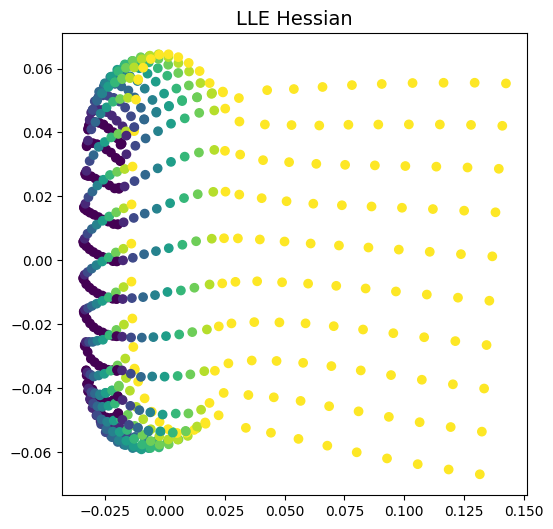

In [119]:
points = ob_points.copy()
color = ob_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="hessian", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE Hessian', size=14)

Text(0.5, 1.0, 'LLE modified')

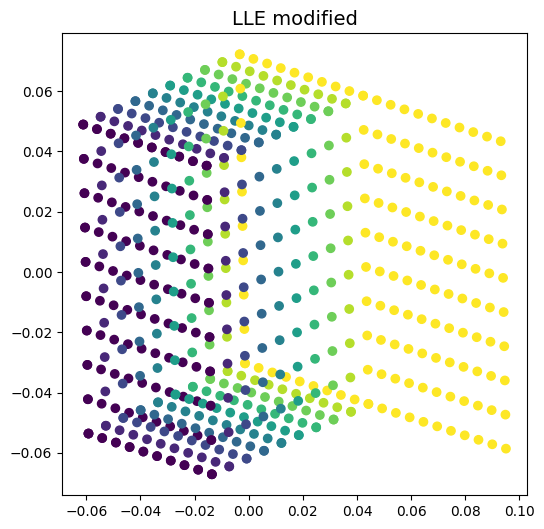

In [118]:
points = ob_points.copy()
color = ob_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="modified", **params)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE modified', size=14)

Text(0.5, 1.0, 'MDS')

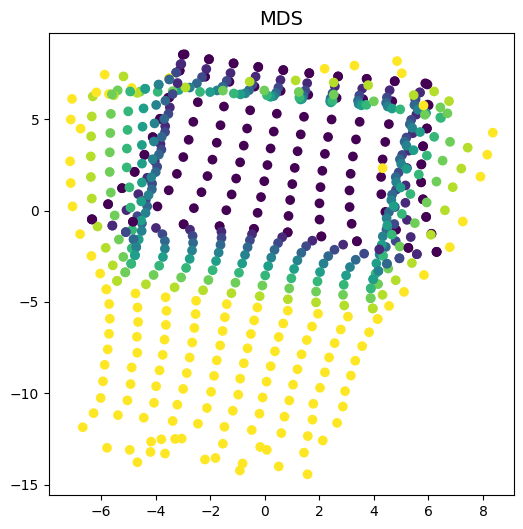

In [98]:
points = ob_points.copy()
color = ob_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

Text(0.5, 1.0, 'MDS')

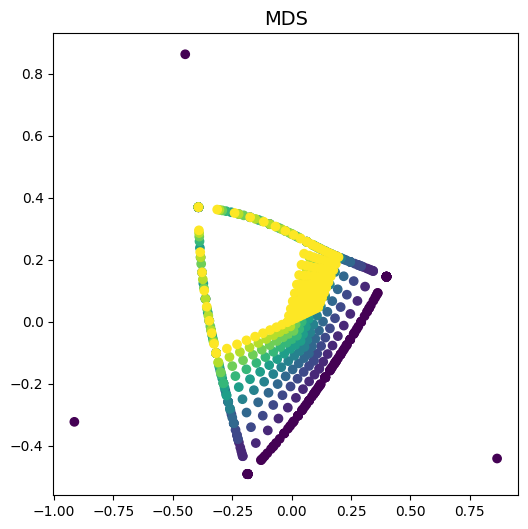

In [99]:
points = ob_points.copy()
color = ob_color.copy()
dis_matrix = pairwise_distances(points, metric = 'cosine')
fig = plt.figure(figsize=(6,6))
model = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
    dissimilarity="precomputed"
)
X = model.fit_transform(dis_matrix)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

Text(0.5, 1.0, 'MDS')

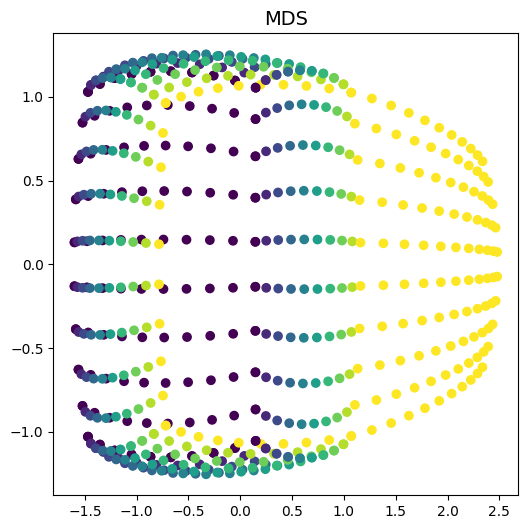

In [100]:
points = ob_points.copy()
color = ob_color.copy()
mds = MDS()
X = mds.fit_transform(points)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

Text(0.5, 1.0, 'Spectral Embedding')

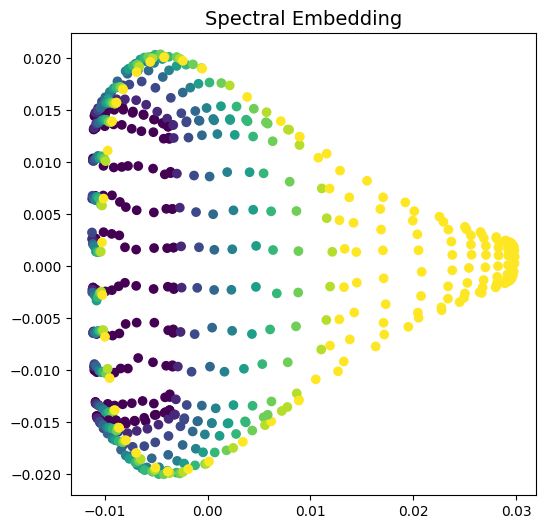

In [101]:
points = ob_points.copy()
color = ob_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors, random_state=42
)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('Spectral Embedding', size=14)

TolFun exceeded: Optimisation terminated


Text(0.5, 1.0, 'Sammon')

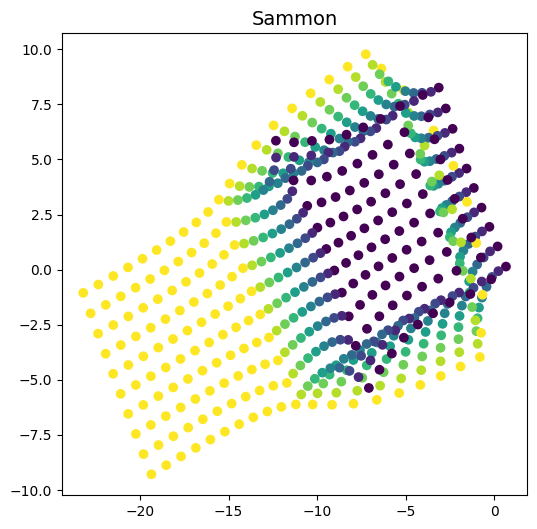

In [102]:
points = ob_points.copy()
color = ob_color.copy()
(sp,index) = np.unique(points,axis=0,return_index=True)
(y,E) = sammon(sp, 2)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y[:, 0], y[:, 1], c=color[index])
ax.set_title('Sammon', size=14)

/Users/lucianosanchez/dataenv3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


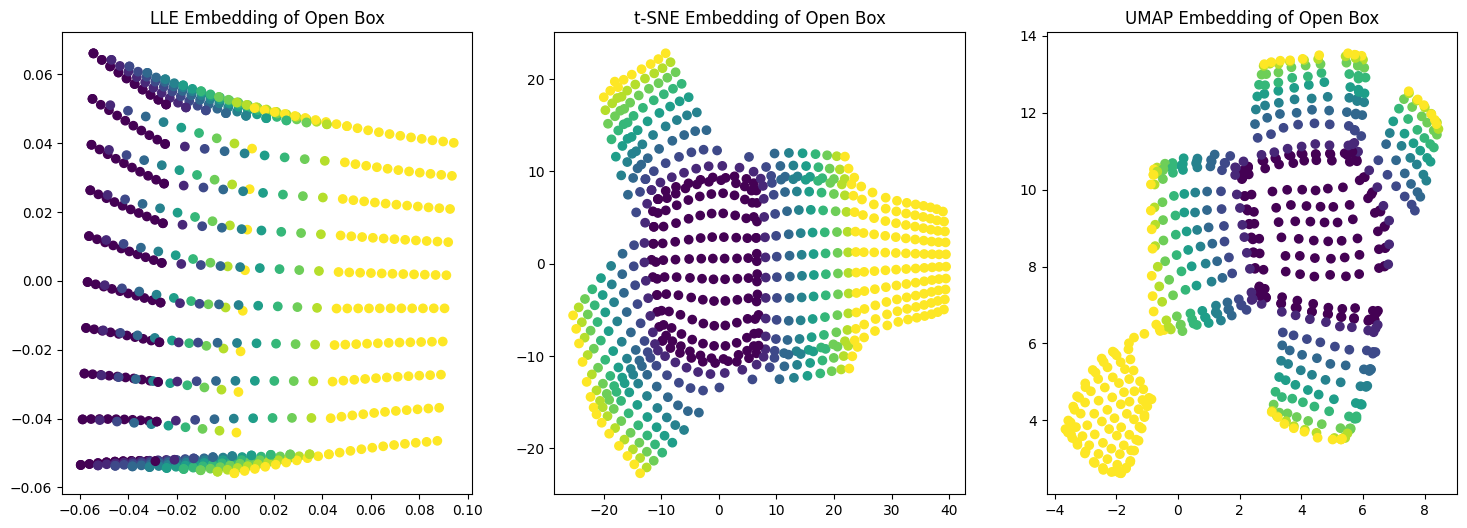

In [128]:
points = ob_points.copy()
color = ob_color.copy()
sr_lle, sr_err = manifold.locally_linear_embedding(
    points, n_neighbors=12, n_components=2
)

sr_tsne = manifold.TSNE(n_components=2, perplexity=40, random_state=0).fit_transform(
    points
)

pumap = UMAP(n_components=2, init="random", random_state=0)
sr_umap = pumap.fit_transform(points)

fig, axs = plt.subplots(figsize=(18, 6), ncols=3)
axs[0].scatter(sr_lle[:, 0], sr_lle[:, 1], c=color)
axs[0].set_title("LLE Embedding of Open Box")
axs[1].scatter(sr_tsne[:, 0], sr_tsne[:, 1], c=color)
_ = axs[1].set_title("t-SNE Embedding of Open Box")
axs[2].scatter(sr_umap[:, 0], sr_umap[:, 1], c=color)
_ = axs[2].set_title("UMAP Embedding of Open Box")

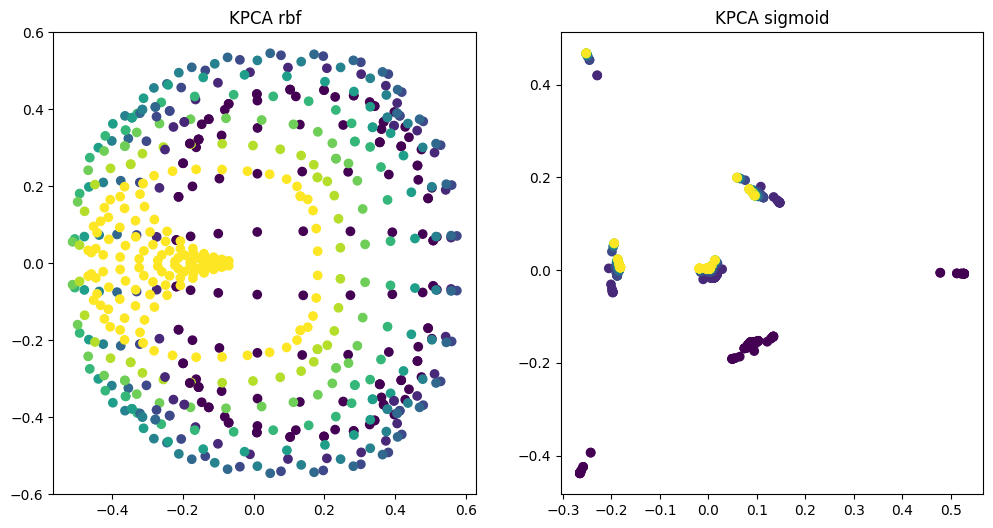

In [116]:

points = ob_points.copy()
color = ob_color.copy()
transformer_1 = KernelPCA(n_components=2, kernel='rbf',gamma=0.05)
kpca_1 = transformer_1.fit_transform(points)
transformer_2 = KernelPCA(n_components=2, kernel='sigmoid')
kpca_2 = transformer_2.fit_transform(points)
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].scatter(kpca_1[:, 0], kpca_1[:, 1], c=color)
axs[0].set_title("KPCA rbf")
axs[1].scatter(kpca_2[:, 0], kpca_2[:, 1], c=color)
_ = axs[1].set_title("KPCA sigmoid")